### Importing necessary libraries


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn as sk
import seaborn as sns

### Importing data

In [ ]:
# Generation Data of Plant 1
df_gp1 = pd.read_csv('/content/drive/MyDrive/assistance_systems/Plant_1_Generation_Data.csv')
# Sensor Data of Plant 1
df_sp1 = pd.read_csv('/content/drive/MyDrive/assistance_systems/Plant_1_Weather_Sensor_Data.csv')
# Generation Data of Plant 2
df_gp2 = pd.read_csv('/content/drive/MyDrive/assistance_systems/Plant_2_Generation_Data.csv')
# Sensor Data of Plant 2
df_sp2 = pd.read_csv('/content/drive/MyDrive/assistance_systems/Plant_2_Weather_Sensor_Data.csv')

In [ ]:
df_list = [ df_gp1, df_sp1, df_gp2, df_sp2 ]

In [ ]:
# Gets the name of the first declared variable in which the data frame is stored
def get_df_name(df):
    name =[x for x in globals() if globals()[x] is df][0]
    return name

In [ ]:
for df in df_list:
  print(f"Dataframe: {get_df_name(df)}")
  print(df.head(4))
  print( "\nDataframe Info:")
  print(df.info())
  print( "\nDataframe quick statistics")
  print(df.describe())
  print( "\n################\n")

Dataframe: df_gp1
          DATE_TIME  PLANT_ID       SOURCE_KEY  DC_POWER  AC_POWER  \
0  15-05-2020 00:00   4135001  1BY6WEcLGh8j5v7       0.0       0.0   
1  15-05-2020 00:00   4135001  1IF53ai7Xc0U56Y       0.0       0.0   
2  15-05-2020 00:00   4135001  3PZuoBAID5Wc2HD       0.0       0.0   
3  15-05-2020 00:00   4135001  7JYdWkrLSPkdwr4       0.0       0.0   

   DAILY_YIELD  TOTAL_YIELD  
0          0.0    6259559.0  
1          0.0    6183645.0  
2          0.0    6987759.0  
3          0.0    7602960.0  

Dataframe Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 68778 entries, 0 to 68777
Data columns (total 7 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   DATE_TIME    68778 non-null  object 
 1   PLANT_ID     68778 non-null  int64  
 2   SOURCE_KEY   68778 non-null  object 
 3   DC_POWER     68778 non-null  float64
 4   AC_POWER     68778 non-null  float64
 5   DAILY_YIELD  68778 non-null  float64
 6   TOTAL_YIELD  68

I want to convert the time column to a timestamp as they are stored as objects in order to be able to merge the tables together later.

> _Notice:_ The first dataframe has a different date format so I will have to work separately with that one.

In [ ]:
day_first_format = "%d-%m-%Y %H:%M" # Also it doesn't have the seconds
year_first_format = "%Y-%m-%d %H:%M:%S"

In [ ]:
for df in df_list:

  if (get_df_name(df) == "df_gp1"):
    df.DATE_TIME = pd.to_datetime(df.DATE_TIME, format=day_first_format, exact=True)
  else:
    df.DATE_TIME = pd.to_datetime(df.DATE_TIME, format=year_first_format, exact=True)

Now I would like to check there is no duplicated timestamp in the sensored data as there is only one sensor station.

Plant 1:

In [ ]:
len(df_sp1.DATE_TIME.unique()) == len(df_sp1.DATE_TIME)

True

Plant 2:

In [ ]:
len(df_sp2.DATE_TIME.unique()) == len(df_sp2.DATE_TIME)

True

## Merge of Plant 1

Next check: for each timestamp of the generated energy data I want to see if there is a registry of environmental data in the sensors dataframe.

Plant 1:

In [ ]:
'''
no_sensored = []
no_sensored_index = []

for i, ts in enumerate(list(df_gp1.DATE_TIME)):
  if ts not in list(df_sp1.DATE_TIME):
    no_sensored_index.append(i)
    no_sensored.append(ts)
'''

'\nno_sensored = []\nno_sensored_index = []\n\nfor i, ts in enumerate(list(df_gp1.DATE_TIME)):\n  if ts not in list(df_sp1.DATE_TIME):\n    no_sensored_index.append(i)\n    no_sensored.append(ts)\n'

In [ ]:
# print(no_sensored)
# print(no_sensored_index)

There is only one time which has no meassured data from the environment and it is: `'2020-06-03 14:00:00'`. We can delete the four registries with that time and it would not impact the results significally.

In [ ]:
df2_gp1 = df_gp1.drop([38544, 38545, 38546, 38547], axis=0)

In [ ]:
len(df2_gp1)

68774

Now every timestamp of the generated data should match a timestamp in the sensored dataset, i.e. We can merge them expecting no conflicts.

In [ ]:
merge_p1 = pd.merge(df2_gp1, df_sp1, how="left", left_on="DATE_TIME", right_on="DATE_TIME")

Now the variable `merged_p1` contains a df with all the data (both generated and sensored) from the plant 1. We could probably drop some of the columns which we will not be using for the predictive model such as the ID's of the plant

DC_POWER: Amount of DC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.

AC_POWER: Amount of AC power generated by the inverter (source_key) in this 15 minute interval. Units - kW.

Basic functioning of the inverter:
```
                 DC_POWER               AC_POWER
Photovoltaics ------------> Inverter ---------------> High voltage tower/cable
```

In [ ]:
merge_p1.head()

,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.0,6259559.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15,4135001,1IF53ai7Xc0U56Y,0.0,0.0,0.0,6183645.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15,4135001,3PZuoBAID5Wc2HD,0.0,0.0,0.0,6987759.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15,4135001,7JYdWkrLSPkdwr4,0.0,0.0,0.0,7602960.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15,4135001,McdE0feGgRqW7Ca,0.0,0.0,0.0,7158964.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


## Merge of plant 2

All the same but for the other two dataframes

In [ ]:
# no_sensored = []
# no_sensored_index = []

# for i, ts in enumerate(list(df_gp2.DATE_TIME)):
#   if ts not in list(df_sp2.DATE_TIME):
#     no_sensored_index.append(i)
#     no_sensored.append(ts)

In [ ]:
# print(no_sensored)
# print(no_sensored_index)

In [ ]:
merge_p2 = pd.merge(df_gp2, df_sp2, how="left", left_on="DATE_TIME", right_on="DATE_TIME")

In [ ]:
merge_p2.head()

,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4136001,4UPUqMRk7TRMgml,0.0,0.0,9425.000000,2.429011e+06,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
1,2020-05-15,4136001,81aHJ1q11NBPMrL,0.0,0.0,0.000000,1.215279e+09,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
2,2020-05-15,4136001,9kRcWv60rDACzjR,0.0,0.0,3075.333333,2.247720e+09,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
3,2020-05-15,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
4,2020-05-15,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0


## Concatenate dataframes of both plants into a unique dataframe

In [ ]:
frames = [merge_p1, merge_p2]

In [ ]:
df = pd.concat(frames)

In [ ]:
len(df)

136472

In [ ]:
df.sort_values("DATE_TIME").head()

,DATE_TIME,PLANT_ID_x,SOURCE_KEY_x,DC_POWER,AC_POWER,DAILY_YIELD,TOTAL_YIELD,PLANT_ID_y,SOURCE_KEY_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15,4135001,1BY6WEcLGh8j5v7,0.0,0.0,0.000000,6.259559e+06,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15,4136001,Et9kgGMDl729KT4,0.0,0.0,269.933333,1.704250e+06,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
4,2020-05-15,4136001,IQ2d7wF4YD8zU1Q,0.0,0.0,3177.000000,1.994153e+07,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
5,2020-05-15,4136001,LYwnQax7tkwH5Cb,0.0,0.0,1872.500000,1.794959e+09,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0
6,2020-05-15,4136001,LlT2YUhhzqhg5Sw,0.0,0.0,1094.357143,2.825928e+08,4136001,iq8k7ZNt4Mwm3w0,27.004764,25.060789,0.0


Now we have a general df with all the data :)

I will drop the columns of yield and download the clean dataframe as they will not be useful to train the model

In [ ]:
final_df = df.drop(['DAILY_YIELD', 'TOTAL_YIELD'], axis=1)

In [ ]:
final_df = final_df.rename(columns={'SOURCE_KEY_x': 'INVERTER_KEY', 'SOURCE_KEY_y': 'SENSOR_KEY'})

In [ ]:
final_df.head(50)

,DATE_TIME,PLANT_ID_x,INVERTER_KEY,DC_POWER,AC_POWER,PLANT_ID_y,SENSOR_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
5,2020-05-15 00:00:00,4135001,VHMLBKoKgIrUVDU,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
6,2020-05-15 00:00:00,4135001,WRmjgnKYAwPKWDb,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
7,2020-05-15 00:00:00,4135001,ZnxXDlPa8U1GXgE,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
8,2020-05-15 00:00:00,4135001,ZoEaEvLYb1n2sOq,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
9,2020-05-15 00:00:00,4135001,adLQvlD726eNBSB,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0


Download to csv

In [ ]:
final_df.to_csv('./drive/MyDrive/assistance_systems/plants_training_data.csv')

In [ ]:
df_gp1.PLANT_ID.unique()

array([4135001])

In [ ]:
print([str(date) for date in list(df_gp1.DATE_TIME)])

['2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:00:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:15:00', '2020-05-15 00:30:00', '2020-05-1

To get a nice visual of the amount of AC/DC power accumulated throughout the day i will limit the timeframe that will be plotted to 24 hours.

In [ ]:
final_df[(final_df.DATE_TIME >= "2020-05-15 00:00:00") & (final_df.DATE_TIME < "2020-05-16 00:00:00")]

,DATE_TIME,PLANT_ID_x,INVERTER_KEY,DC_POWER,AC_POWER,PLANT_ID_y,SENSOR_KEY,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
0,2020-05-15 00:00:00,4135001,1BY6WEcLGh8j5v7,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
1,2020-05-15 00:00:00,4135001,1IF53ai7Xc0U56Y,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
2,2020-05-15 00:00:00,4135001,3PZuoBAID5Wc2HD,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
3,2020-05-15 00:00:00,4135001,7JYdWkrLSPkdwr4,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
4,2020-05-15 00:00:00,4135001,McdE0feGgRqW7Ca,0.0,0.0,4135001,HmiyD2TTLFNqkNe,25.184316,22.857507,0.0
...,...,...,...,...,...,...,...,...,...,...
2085,2020-05-15 23:45:00,4136001,q49J1IKaHRwDQnt,0.0,0.0,4136001,iq8k7ZNt4Mwm3w0,26.755832,24.814484,0.0
2086,2020-05-15 23:45:00,4136001,rrq4fwE8jgrTyWY,0.0,0.0,4136001,iq8k7ZNt4Mwm3w0,26.755832,24.814484,0.0
2087,2020-05-15 23:45:00,4136001,vOuJvMaM2sgwLmb,0.0,0.0,4136001,iq8k7ZNt4Mwm3w0,26.755832,24.814484,0.0
2088,2020-05-15 23:45:00,4136001,xMbIugepa2P7lBB,0.0,0.0,4136001,iq8k7ZNt4Mwm3w0,26.755832,24.814484,0.0


We get thousands of rows for only one day, this is due to multiple iverters being used in a plant and thus we have multiple values per timestamp

In [ ]:
df_first_day = final_df[(final_df.DATE_TIME >= "2020-05-15 00:00:00") & (final_df.DATE_TIME < "2020-05-16 00:00:00")].groupby('DATE_TIME').sum('DC_POWER')
df_first_day

,PLANT_ID_x,DC_POWER,AC_POWER,PLANT_ID_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,
2020-05-15 00:00:00,177827043,0.0,0.0,177827043,1122.975440,1031.345011,0.0
2020-05-15 00:15:00,177827043,0.0,0.0,177827043,1118.154214,1015.276140,0.0
2020-05-15 00:30:00,177827043,0.0,0.0,177827043,1110.656022,1011.838803,0.0
2020-05-15 00:45:00,177827043,0.0,0.0,177827043,1104.781694,1006.832802,0.0
2020-05-15 01:00:00,181962044,0.0,0.0,181962044,1126.788814,1039.579927,0.0
...,...,...,...,...,...,...,...
2020-05-15 22:30:00,181962044,0.0,0.0,181962044,1107.339103,1048.925571,0.0
2020-05-15 22:45:00,181962044,0.0,0.0,181962044,1104.457347,1052.966432,0.0
2020-05-15 23:00:00,181962044,0.0,0.0,181962044,1098.801281,1050.964452,0.0


I grouped the rows based on the sum of the values for every 15 mins. This will give us a clearer look of the evolution of certain features throughout the day.

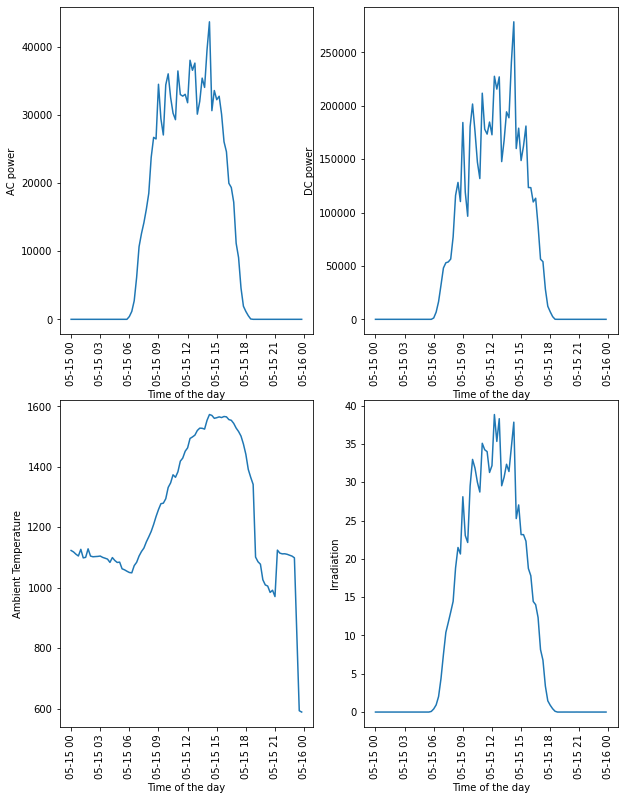

In [ ]:
plt.figure(1, figsize=(10,10))
plt.subplot(2,2,1)
plt.ylabel('AC power')
plt.xlabel('Time of the day')
plt.xticks(rotation='vertical')
plt.plot(df_first_day.AC_POWER)
plt.subplots_adjust(bottom=2, top = 3)
plt.subplot(2,2,2)
plt.ylabel('DC power')
plt.xlabel('Time of the day')
plt.xticks(rotation='vertical')
plt.plot(df_first_day.DC_POWER)
plt.subplot(2,2,3)
plt.ylabel('Ambient Temperature')
plt.xlabel('Time of the day')
plt.xticks(rotation='vertical')
plt.plot(df_first_day.AMBIENT_TEMPERATURE)
plt.subplot(2,2,4)
plt.ylabel('Irradiation')
plt.xlabel('Time of the day')
plt.xticks(rotation='vertical')
plt.plot(df_first_day.IRRADIATION)

As expected AC and DC power are highly correlated, and also irradiation has a high correlation with AC/DC power. However when ambient temperature increases at the end of the day there is no increase in the AC/DC power, so this variable will be left out in the prediction model.

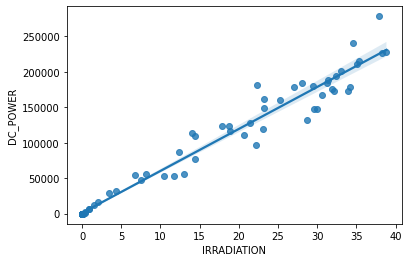

In [ ]:
sns.regplot(x = df_first_day.IRRADIATION, y = df_first_day.DC_POWER)

In [ ]:
df_first_day.IRRADIATION.corr(df_first_day.DC_POWER)

0.9852326596103439

As we can see there is a high correlation of a value higher than 9.8 between the irradiation and the DC power so this variable will be selected for the prediction, since AC and DC power are directly derived from each other, we will only use one of them.

Since the relationship between the variables is linear, it would make sense to use a linear regression algorithm to predict values.

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = df_first_day.IRRADIATION
y = df_first_day.DC_POWER
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
arr = x_train.array
x_train = arr.reshape(-1,1)
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import r2_score
arr1 = x_test.array
x_test = arr1.reshape(-1,1)
y_pred = lr.predict(x_test)
r2_score(y_pred, y_test)

0.9668286871745103

Our regression model's prediction has a very high accuracy > 9.8

In [ ]:
final_df_agg = final_df.groupby('DATE_TIME').sum('DC_POWER')

In [ ]:
final_df_agg.to_csv('./drive/MyDrive/assistance_systems/plant_training_data.csv')
final_df_agg.head()

,PLANT_ID_x,DC_POWER,AC_POWER,PLANT_ID_y,AMBIENT_TEMPERATURE,MODULE_TEMPERATURE,IRRADIATION
DATE_TIME,,,,,,,
2020-05-15 00:00:00,177827043,0.0,0.0,177827043,1122.975440,1031.345011,0.0
2020-05-15 00:15:00,177827043,0.0,0.0,177827043,1118.154214,1015.276140,0.0
2020-05-15 00:30:00,177827043,0.0,0.0,177827043,1110.656022,1011.838803,0.0
2020-05-15 00:45:00,177827043,0.0,0.0,177827043,1104.781694,1006.832802,0.0
2020-05-15 01:00:00,181962044,0.0,0.0,181962044,1126.788814,1039.579927,0.0


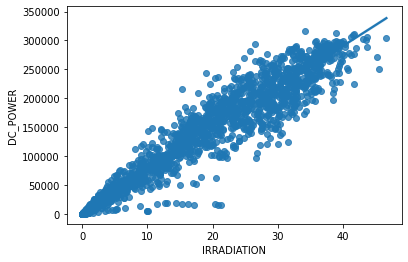

In [ ]:
sns.regplot(x = final_df_agg.IRRADIATION, y = final_df_agg.DC_POWER)

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

x = final_df_agg.IRRADIATION
y = final_df_agg.DC_POWER
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.3)
arr = x_train.array
x_train = arr.reshape(-1,1)
lr = LinearRegression()
lr.fit(x_train, y_train)

LinearRegression()

In [ ]:
from sklearn.metrics import r2_score
arr1 = x_test.array
x_test = arr1.reshape(-1,1)
y_pred = lr.predict(x_test)
r2_score(y_pred, y_test)

0.949636917404965

In [ ]:
final_df_agg.IRRADIATION.max()

46.60901312463054